# Calificación de vinos basado en mediciones fisicoquímicas

El presente trabajo consiste en analizar un conjunto de datos con mediciones fisicoquímicas de diferentes tipos de vinos, tanto blancos como tintos. Inicialmente, como análisis exploratorio de datos se buscará establecer la relación de ciertas mediciones con la calidad del vino, por ejemplo, que relación tiene los grados de alcohol de un vino con su calidad.<br>
<br>
Posteriormente, se desarrollarán algunos modelos para intentar predecir:
<br>
1. La calidad del vino basado en sus características fisicoquímicas<br>
2. El tipo de vino (tinto o blanco) basado en sus características fisicoquímicas

Inicialmente, vamos a cargar el conjunto de datos, los datos originales provienen de 2 archivos, uno de vinos blancos, con 4898 observaciones y otro de vinos tintos con 1599 observaciones. Cada conjunto de datos tiene 12 atributos, se agregó un atributo adicional para identificar si las mediciones son de un vino tinto o blanco y se agruparon en un único conjunto de datos final de 6497 observaciones y 13 atributos.

### Carga de librerias

In [55]:
#importar numpu, pandas, scipy, math, matplotlib
import numpy as np
import pandas as pd
import scipy 
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#estimadores
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import GaussianNB

#metricas para modelos
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#validacion cruzada
from sklearn.model_selection import train_test_split

### Carga de conjunto de datos

In [4]:
#data
datos_originales = pd.read_csv('winequality-final.csv', header=0)
datos_originales.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type
0,6.7,0.19,0.32,3.7,0.041,26.0,76.0,0.99173,2.90,0.57,10.5,7,White
1,6.8,0.25,0.27,10.7,0.076,47.0,154.0,0.99670,3.05,0.38,9.0,5,White
2,6.2,0.15,0.46,1.6,0.039,38.0,123.0,0.99300,3.38,0.51,9.7,6,White
3,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5,Red
4,6.8,0.29,0.56,11.9,0.043,66.0,230.0,0.99720,3.02,0.63,9.3,5,White


Vamos a examinar la estructura de datos y validar los formatos de los atributos cargados

In [5]:
datos_originales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
fixed_acidity           6497 non-null float64
volatile_acidity        6497 non-null float64
citric_acid             6497 non-null float64
residual_sugar          6497 non-null float64
chlorides               6497 non-null float64
free_sulfur_dioxide     6497 non-null float64
total_sulfur_dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
type                    6497 non-null object
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [8]:
datos_originales['type'] = datos_originales['type'].astype('category')

In [9]:
datos_originales.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### Análisis de datos exploratorio

Lo primero es analizar la relación que puede llegar a tener las diferentes mediciones con la calidad, es importante recordar que la calidad del vino es un valor entre 0 y 10, entre mayor sea el valor mejor será el vino. También se investigará si las mediciones tienen alguna relación con el tipo de vino (tinto o blanco).

Inicialmente, vamos a analizar como se encuentra la distribución de vinos, tanto por calidad como por tipo.

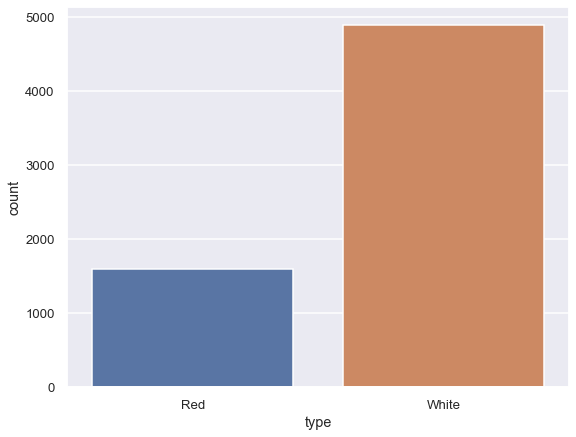

In [22]:
p = sns.countplot(data=datos_originales, x = 'type')

Como se puede apreciar, entre los datos existe una cantidad mayor cantidad de vinos blancos que tintos, casi 3 veces más.

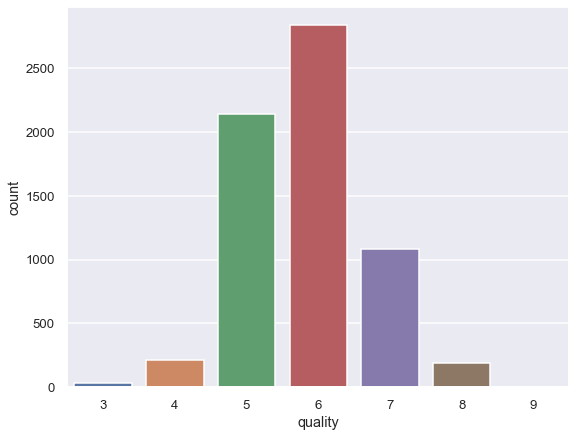

In [20]:
p = sns.countplot(data=datos_originales, x = 'quality')

En esta gráfica, se puede observar las diferentes calificaciones que hay de los vinos, existiendo una gran preponderancia de vinos de calidad media. Es importante notar que no hay vinos con calificaciones de 0, 1 y 2, ni tampoco vinos con calificación 10.

Ahora, vamos a llevar a cabo un análisis de correlación entre las variables para entender como se relacionan entre ellas y posteriormente visualizar dichas correlaciones.

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type
fixed_acidity,1.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452,-0.076743,0.486740
volatile_acidity,0.219008,1.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640,-0.265699,0.653036
citric_acid,0.324436,-0.377981,1.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493,0.085532,-0.187397
residual_sugar,-0.111981,-0.196011,0.142451,1.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415,-0.036980,-0.348821
chlorides,0.298195,0.377124,0.038998,-0.128940,1.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916,-0.200666,0.512678
free_sulfur_dioxide,-0.282735,-0.352557,0.133126,0.402871,-0.195045,1.000000,0.720934,0.025717,-0.145854,-0.188457,-0.179838,0.055463,-0.471644
total_sulfur_dioxide,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,1.000000,0.032395,-0.238413,-0.275727,-0.265740,-0.041385,-0.700357
density,0.458910,0.271296,0.096154,0.552517,0.362615,0.025717,0.032395,1.000000,0.011686,0.259478,-0.686745,-0.305858,0.390645
pH,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,0.011686,1.000000,0.192123,0.121248,0.019506,0.329129
sulphates,0.299568,0.225984,0.056197,-0.185927,0.395593,-0.188457,-0.275727,0.259478,0.192123,1.000000,-0.003029,0.038485,0.487218


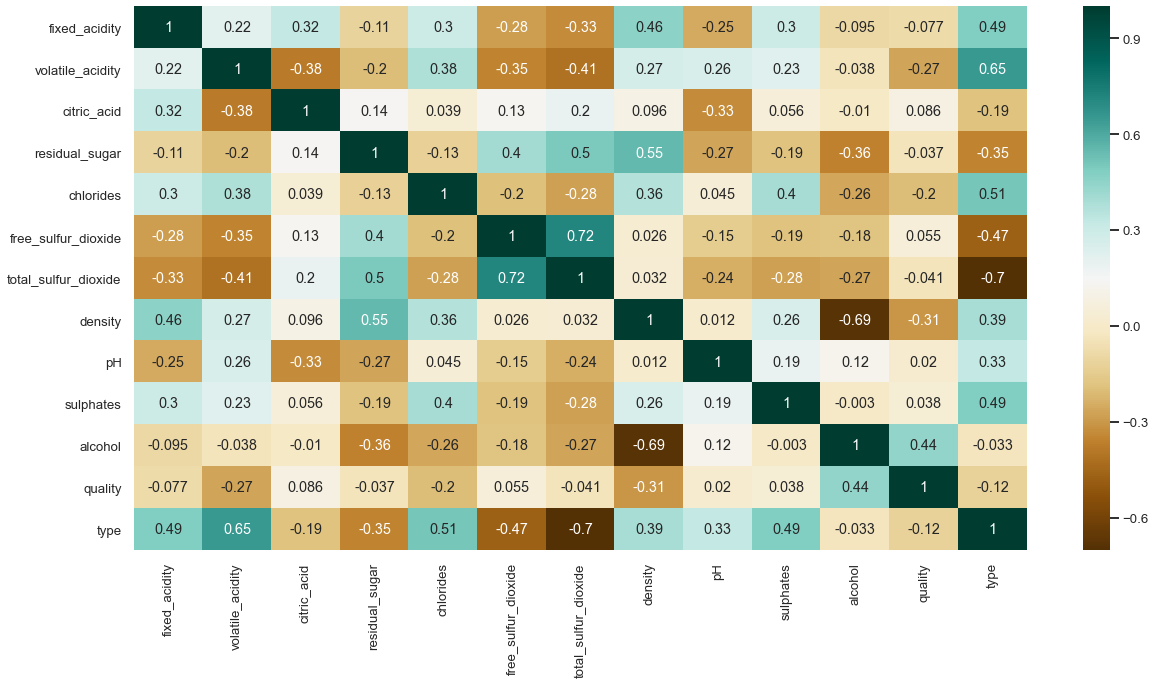

In [379]:
plt.figure(figsize=(20,10))
correlacion2 = datos_originales.corr()
sns.heatmap(correlacion2,cmap="BrBG",annot=True)
correlacion2

De la matriz de correlación es posible notar que no existe una correlación fuerte entre la calidad y alguna otra medición, la más alta es el alcohol y no es tan significativa (0.44). También se puede notar qeu existe una correlación significativa entre el dióxido de azufre libre y dióxido de azufre total. Por último, notar que existe relaciones intermedias que probablemente ayuden a determinar el tipo de vino basado en los sulfatos, la densidad, los cloruros, acidez volátil y acidez fija.

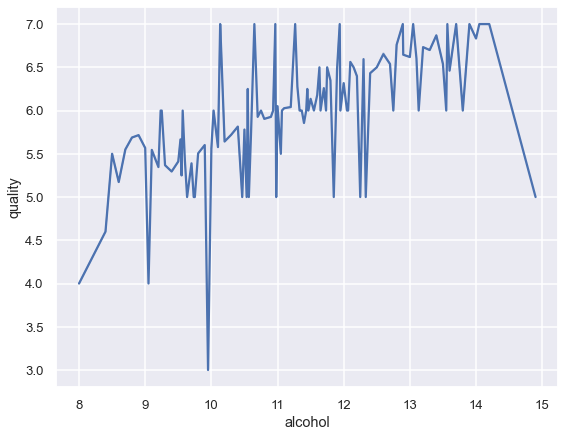

In [37]:
ax = sns.lineplot(x="alcohol", y="quality", ci=0, data=datos_originales)

De la gráfica anterior podemos determinar que la mayor concentración de vinos de calidad media y media alta se encuentran entre los 10 y los 14 grados de alcohol, mientras que la mayoria de los vinos de calidad baja son de menos de 10 grados de alcohol.

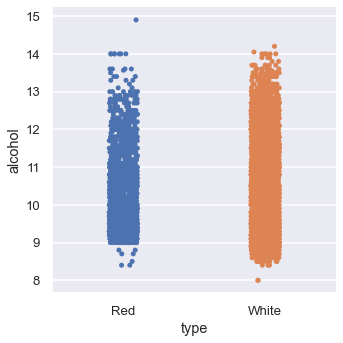

In [40]:
sns.catplot(x="type", y="alcohol", data=datos_originales);

Podemos rescartar del gráfico anterior que muy rara vez existen vinos tintos con menos de 9 grados de alcohol, a su vez tampoco hay muchas observaciones en vinos tintos con más de 13 grados de alcohol. De los vinos blancos podemos decir que su mayor concentración se encuentran entre los 8.5 grados y los 13 grados.

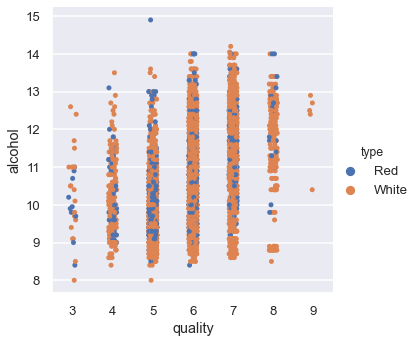

In [42]:
sns.catplot(x="quality", y="alcohol", hue="type", data=datos_originales);

La gráfica anterior pretende encontrar la relación entre los grados de alcohol, la calidad y el tipo de vino. Al ser menos los vinos con calidad bastante alta (8 y 9) habrán menos observaciones, pero podemos observar que la mayoría de vinos de alta calidad se encuentran entre los 10 y los 13 grados de alcohol. No obstante, como ya habiamos observado anteriormente, la correlación entre los grados de alcohol y la calidad no es determinante en este conjunto de datos analizados. Por último, es interesante notar que solo los vinos blancos lograron la calificación de 9 en calidad.

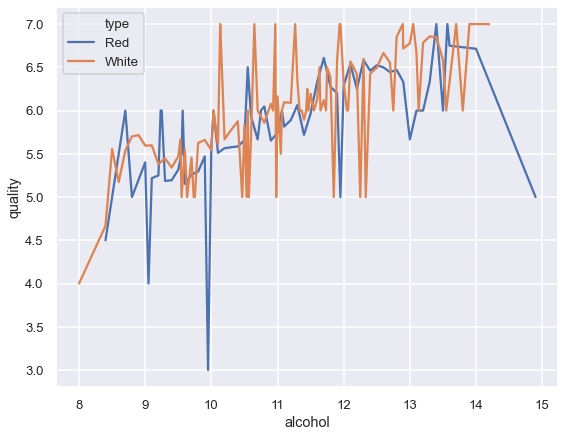

In [44]:
x = sns.lineplot(x="alcohol", y="quality", hue="type", ci=0, data=datos_originales)

Intentando analizar los mismos datos desde una forma distinta, podemos asegurar que la mayoría de vinos, independientemente de su tipo (blanco o tinto) con calificación de calidad de 5 o superior se encuentran entre los los 10 y 14 grados de alcohol. Por tanto, podemos decir que difilmente un vino de calidad superior tendrá mas de 14 grados de alcohol o menos de 10 grados.

Como conclusiones, del presente análisis de datos podemos determinar:<br>
1. El conjunto de datos presenta un desbalance entre la cantidad de vinos tinos y blancos.<br>
2. La mayoria de vinos presentan una calificación de calidad entre 5 y 7, por tanto, podemos saber que existe una probabilidad muy baja de lograr puntajes muy bajos o muy altos en base a las mediciones.<br>
3. No existe un atributo altamente relacionado de las mediciones fisicoquímicas y la calidad del vino.<br>
4. Como se pudo observar en la matriz de correlación y en el gráfico de análisis de calidad y grados de alcohol, la mayoría de vinos de calidad superior a 5, tienen un grado de alcohol entre 10 y 14.<br>
5. La grand cantidad de vinos tintos muestreados tienen una graduación alcohólica entre 9 y 13, mientras que los vinos blancos tienen una graduación entre 8,5 y 14.<br>
6. En el conjunto de datos analizado solo existen vinos de muy alta calidad (9) blancos.

## Desarrollo de modelos

### Modelo de predicción de calidad del vino

En el análisis anterior no se logró encontrar alguna medición altamente relacionada con la calidad. Ahora, vamos a desarrollar algunos modelos para intentar determinar con la mayor precisión posible la calidad de un vino basado en sus mediciones fisicoquímicas, además, también se intentará desarrollar modelos para predecir el tipo de vino (tinto o blanco) badado en dichas mediciones.

Considerando que la calificación debe ser un un rango entre 0 y 10, no existiendo decimales ni negativos, vamos a convertir la calificación a una variable de tipo categórica y desarrollaremos ambos modelos como clasificaciones.

In [45]:
datos_originales['quality'] = datos_originales['quality'].astype('category')

In [46]:
datos_originales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
fixed_acidity           6497 non-null float64
volatile_acidity        6497 non-null float64
citric_acid             6497 non-null float64
residual_sugar          6497 non-null float64
chlorides               6497 non-null float64
free_sulfur_dioxide     6497 non-null float64
total_sulfur_dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null category
type                    6497 non-null category
dtypes: category(2), float64(11)
memory usage: 571.6 KB


Primeramente vamos a seleccionar las características, que en este caso serán los predictores del modelo:

In [48]:
caracteristicas = datos_originales.iloc[:,0:11]
print('Resumen de muestra de características')
caracteristicas.head()

Resumen de muestra de características


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,6.7,0.19,0.32,3.7,0.041,26.0,76.0,0.99173,2.90,0.57,10.5
1,6.8,0.25,0.27,10.7,0.076,47.0,154.0,0.99670,3.05,0.38,9.0
2,6.2,0.15,0.46,1.6,0.039,38.0,123.0,0.99300,3.38,0.51,9.7
3,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.99780,3.35,0.80,10.5
4,6.8,0.29,0.56,11.9,0.043,66.0,230.0,0.99720,3.02,0.63,9.3


Ahora vamos a seleccionar la variable dependiente para nuestra predicción de calidad:

In [49]:
depVarCalidad = datos_originales['quality']

Una vez elegidas las variables predictoras y la variable a predecir, vamos a establecer los conjuntos de datos (entrenamiento X & Y, pruebas X & Y, 70/30)

In [51]:
x_train, x_test, y_train, y_test = train_test_split(caracteristicas, 
                                                    depVarCalidad, test_size=0.3, random_state=101)

Para continuar con el desarrollo de los modelos vamos a validar que el establecimiento de los conjuntos de datos de entrenamiento y pruebas estén correctos:

In [58]:
x_train.head()
x_train_count = x_train.index
print('El número de observaciones en el conjunto de entrenamiento X es:',str(x_train_count))

x_test.head()
x_test_count = x_test.index
print('El número de observaciones en el conjunto de pruebas X es:',str(x_test_count))

y_train.head()
y_train_count = y_train.index
print('El número de observaciones en el conjunto de entrenamiento Y es:',str(y_train_count))

y_test.head()
y_test_count = y_test.index
print('El número de observaciones en el conjunto de pruebas Y es:',str(y_test_count))

El número de observaciones en el conjunto de entrenamiento X es: Int64Index([3416, 2234, 4863, 5724, 4082,  148, 1110, 2568, 1001, 5290,
            ...
            5672,  973, 4079, 4171, 6141,  599, 5695, 1361, 1547, 4959],
           dtype='int64', length=4547)
El número de observaciones en el conjunto de pruebas X es: Int64Index([ 868, 5097, 5450, 5850, 2192, 5884, 3024, 1683, 5074,  730,
            ...
              48, 4500, 5938,  242, 3386, 6040, 2890,  914, 1403, 4077],
           dtype='int64', length=1950)
El número de observaciones en el conjunto de entrenamiento Y es: Int64Index([3416, 2234, 4863, 5724, 4082,  148, 1110, 2568, 1001, 5290,
            ...
            5672,  973, 4079, 4171, 6141,  599, 5695, 1361, 1547, 4959],
           dtype='int64', length=4547)
El número de observaciones en el conjunto de pruebas Y es: Int64Index([ 868, 5097, 5450, 5850, 2192, 5884, 3024, 1683, 5074,  730,
            ...
              48, 4500, 5938,  242, 3386, 6040, 2890,  914, 1403

Inicialmente, se desarrollaran modelos basados en el conjunto de datos originales, posteriormente se utilizarán algunos métodos de ingeniería de datos para intentar mejorar los resultados

Se inicializan los clasificadores a utilizar

In [81]:
modelRF = RandomForestClassifier(n_estimators=1000) #random forest
modelLR = LogisticRegression(max_iter=100000) #regresion logistica
modelGNB = GaussianNB() #Gaussian Naive Bayes

Utilizando los conjuntos establecidos anteriormente los vamos a pasar como parte del modelo de entrenamiento

In [82]:
modelRF.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [83]:
modelLR.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [84]:
modelGNB.fit(x_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

Una vez desarrollados los modelos con los conjuntos de datos originales, vamos a evaluar los modelos desarrollados con los conjuntos de datos originales:

In [85]:
modelRF.score(x_train,y_train)

1.0

In [86]:
modelLR.score(x_train,y_train)

0.538596877061799

In [87]:
modelGNB.score(x_train,y_train)

0.44160985265009894

Como se puede observar los modelos desarrollados con el conjunto de datos originales no presentaron resultados favorables para tener un modelo con una precisión aceptable. Vamos a generar un modelo más de Support Vector Machine, con el fin de evaluar uno más. Cabe recalcar que el modelo con el algoritmo Random Forest dió una precisión teórica del 100%, no obstante, esto solo refleja que puede existir un sobre ajuste el modelo.

In [88]:
modelSVC = SVC()

In [90]:
modelSVC.fit(x_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [91]:
modelSVC.score(x_train,y_train)

0.4398504508467121

Con el modelo con algoritmo SVM tampoco se logró un resultado favorable. Ahora vamos a realizar predicciones y ver cual tuvo un mejor comportamiento con los datos de pruebas.

In [93]:
predRFOrig = modelRF.predict(x_test)

cmOrigRF = confusion_matrix(y_test, predRFOrig)
print("Modelo Random Forest - Datos Originales")
print(cmOrigRF)
print('Precisión', accuracy_score(y_test, predRFOrig))

Modelo Random Forest - Datos Originales
[[  0   0   7   4   0   0]
 [  1   6  27  13   2   0]
 [  0   0 475 176   4   0]
 [  0   1 160 664  33   0]
 [  0   0  15 142 164   1]
 [  0   0   1  14  14  26]]
Precisión 0.6846153846153846


In [94]:
predLROrig = modelLR.predict(x_test)

cmOrigLR = confusion_matrix(y_test, predLROrig)
print("Modelo Linear Regression - Datos Originales")
print(cmOrigLR)
print('Precisión', accuracy_score(y_test, predLROrig))

Modelo Linear Regression - Datos Originales
[[  0   0   7   4   0   0]
 [  0   0  29  19   1   0]
 [  0   0 404 249   2   0]
 [  0   0 225 598  35   0]
 [  0   0  31 232  59   0]
 [  0   0   7  34  14   0]]
Precisión 0.5441025641025641


In [96]:
predGNBOrig = modelGNB.predict(x_test)

cmOrigGNB = confusion_matrix(y_test, predGNBOrig)
print("Modelo Gaussian Naive Bayes - Datos Originales")
print(cmOrigGNB)
print('Precisión', accuracy_score(y_test, predGNBOrig))

Modelo Gaussian Naive Bayes - Datos Originales
[[  0   3   3   4   1   0   0]
 [  1   4  19  19   6   0   0]
 [  3  21 317 256  58   0   0]
 [  1  27 229 359 236   5   1]
 [  1   5  40  78 191   3   4]
 [  0   0   6  14  33   2   0]
 [  0   0   0   0   0   0   0]]
Precisión 0.44769230769230767


In [97]:
predSVCOrig = modelSVC.predict(x_test)

cmOrigSVC = confusion_matrix(y_test, predSVCOrig)
print("Modelo SVM - Datos Originales")
print(cmOrigGNB)
print('Precisión', accuracy_score(y_test, predSVCOrig))

Modelo SVM - Datos Originales
[[  0   3   3   4   1   0   0]
 [  1   4  19  19   6   0   0]
 [  3  21 317 256  58   0   0]
 [  1  27 229 359 236   5   1]
 [  1   5  40  78 191   3   4]
 [  0   0   6  14  33   2   0]
 [  0   0   0   0   0   0   0]]
Precisión 0.438974358974359


De los resultados anteriores se mantuvo lo que vimos en la evaluación del modelo, no obstante, Random Forest mostró un rendimiento minimamente aceptable con una presición de un 68%. Ahora vamos a aplicar un poco de ingenieria de datos para intentar mejorar los modelos desarrollados.

#### PCA en modelos de predicción de calidad del vino

PCA es una técnica utilizada para describir un conjunto de datos en términos de nuevas variables ("componentes") no correlacionadas. Los componentes se ordenan por la cantidad de varianza original que describen, por lo que la técnica es útil para reducir la dimensionalidad de un conjunto de datos.<br><br>
No considero que PCA pueda tener un impacto importante, tomando en cuenta que el modelo de datos no tienen una dimensionalidad alta. 

In [100]:
#normalizamos los datos
scaler=StandardScaler()
dfPCA = datos_originales
dfPCA = dfPCA.drop(['quality'], axis=1) # quito la variable dependiente "Y"
X_train_pca = scaler.fit_transform(x_train)
X_test_pca = scaler.transform(x_test) # se escalan los datos y se normalizan

In [101]:
#Instanciamos objeto PCA y aplicamos
pca=PCA(.90) #para lograr el 90%
X_train_pca = pca.fit_transform(X_train_pca)
X_test_pca = pca.transform(X_test_pca)

In [109]:
print("X_train_pca Shape", X_train_pca.shape)
expl = pca.explained_variance_ratio_
print(expl)
print('suma:',sum(expl[0:7]))
#Vemos que con 8 componentes tenemos casi el 90% de varianza explicada

X_train_pca Shape (4547, 8)
[0.2711439  0.22756852 0.14199699 0.08961923 0.06538821 0.05572947
 0.04813865 0.04554102]
suma: 0.8995849821267257


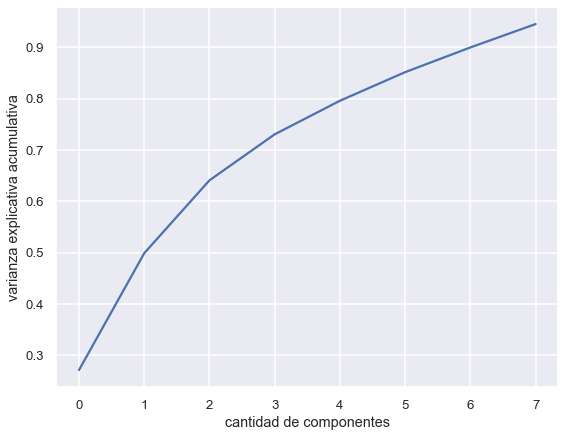

In [110]:
#graficamos el acumulado de varianza explicada en las nuevas dimensiones
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('cantidad de componentes')
plt.ylabel('varianza explicativa acumulativa')
plt.show()

Entrenamiento y predicciones PCA - Random Forest

In [111]:
rfClassifierPCA = RandomForestClassifier()#inicializacion
rfClassifierPCA.fit(X_train_pca, y_train)#entrenamiento
y_pred_pca = rfClassifierPCA.predict(X_test_pca)#prediccion

Evaluación del desempeño modelo PCA - Random Forest

In [117]:
RFcmPCA = confusion_matrix(y_test, y_pred_pca)
print("Modelo Random Forest - PCA")
print(RFcmPCA)
print('Precisión', accuracy_score(y_test, y_pred_pca))

Modelo Random Forest - PCA
[[  0   1   7   3   0   0]
 [  0   5  24  18   2   0]
 [  0   0 465 184   6   0]
 [  0   1 169 650  37   1]
 [  0   0  11 157 154   0]
 [  0   0   2  17  11  25]]
Precisión 0.6661538461538462


Entrenamiento y predicciones PCA - Logistic Regression

In [113]:
lrClassifierPCA = LogisticRegression(max_iter=100000)
lrClassifierPCA.fit(X_train_pca, y_train)
y_pred_pca_LR = lrClassifierPCA.predict(X_test_pca)

Evaluación del desempeño modelo PCA - Logistic Regression

In [118]:
cmPCA_LR = confusion_matrix(y_test, y_pred_pca_LR)
print("Modelo Logistic Regression - PCA")
print(cmPCA_LR)
print('Precisión', accuracy_score(y_test, y_pred_pca_LR))

Modelo Logistic Regression - PCA
[[  0   0   7   4   0   0]
 [  0   0  26  22   1   0]
 [  0   0 384 268   3   0]
 [  0   0 233 587  38   0]
 [  0   0  29 228  65   0]
 [  0   0   8  33  14   0]]
Precisión 0.5312820512820513


Entrenamiento y predicciones PCA - Gaussian Naive Bayes

In [115]:
GNBClassifierPCA = GaussianNB()
GNBClassifierPCA.fit(X_train_pca, y_train)
y_pred_pca_GNB = GNBClassifierPCA.predict(X_test_pca)

Evaluación del desempeño modelo PCA - Gaussian Naive Bayes

In [119]:
cmPCA_GNB = confusion_matrix(y_test, y_pred_pca_GNB)
print("Modelo Gaussian Naive Bayes - PCA")
print(cmPCA_GNB)
print('Precisión', accuracy_score(y_test, y_pred_pca_GNB))

Modelo Gaussian Naive Bayes - PCA
[[  1   2   4   4   0   0]
 [  3   1  20  23   2   0]
 [  8   1 298 341   7   0]
 [ 10   1 184 596  65   2]
 [  3   0  19 210  90   0]
 [  1   0   7  28  17   2]]
Precisión 0.5066666666666667


Entrenamiento y predicciones PCA - Support Vector Machine

In [120]:
SVCClassifierPCA = SVC()
SVCClassifierPCA.fit(X_train_pca, y_train)
y_pred_pca_SVC = SVCClassifierPCA.predict(X_test_pca)

Evaluación del desempeño modelo PCA - Support Vector Machine

In [121]:
cmPCA_SVC = confusion_matrix(y_test, y_pred_pca_SVC)
print("Modelo Support Vector Machine - PCA")
print(cmPCA_SVC)
print('Precisión', accuracy_score(y_test, y_pred_pca_SVC))

Modelo Support Vector Machine - PCA
[[  0   0   7   4   0   0]
 [  0   0  27  21   1   0]
 [  0   0 396 257   2   0]
 [  0   0 205 631  22   0]
 [  0   0  22 242  58   0]
 [  0   0   6  36  13   0]]
Precisión 0.5564102564102564


Después de desarrollar los modelos utilizando PCA vemos que no se logró desarrollar un modelo con una precisión aceptable, los modelos con Random Forest y Logistic Regression tuvieron una pérdida de precisión poco signficativa versus los modelos con los datos originales (2% y 1% respectivamente), mientras tanto los modelos que utilizan los algoritmos Gaussian Naive Bayes y Support Vector Machine tuvieron un aumento en la precisión considerable versus los modelos con los datos originales (6% y 7% respectivamente) aunque lastimosamente no obtuvieron una precisión aceptable para este ejercicio.

### Utilización de RFE

Como habíamos estudiado anteriormente, RFE es un algoritmo de optimización que busca encontrar el subconjunto de funciones con mejor rendimiento. Crea repetidamente modelos y deja de lado la mejor o la peor característica de rendimiento en cada iteración. Construye el siguiente modelo con las características de la izquierda hasta que se agotan todas las características, luego clasifica las características según el orden de su eliminación.

Modelo y entrenamiento RFE - Random Forest

In [122]:
rfeRF = RFE(modelRF, 6)
rfeRF = rfeRF.fit(x_train, y_train)

print("# Caracteristicas: %d" % rfeRF.n_features_)
print("Caracteristicas seleccionadas: %s" % rfeRF.support_)
print("Ranking de caracteristicas: %s" % rfeRF.ranking_)

# Caracteristicas: 6
Caracteristicas seleccionadas: [False  True False False  True False  True  True  True False  True]
Ranking de caracteristicas: [6 1 5 4 1 2 1 1 1 3 1]


Predicción RFE - Random Forest

In [123]:
y_pred_rfe_RF = rfeRF.predict(x_test)

Evaluación de desempeño RFE - Random Forest

In [124]:
cmRFE_RF = confusion_matrix(y_test, y_pred_rfe_RF)
print("Modelo Random Forest - RFE")
print(cmRFE_RF)
print('Precisión', accuracy_score(y_test, y_pred_rfe_RF))

Modelo Random Forest - RFE
[[  0   0   7   4   0   0]
 [  1   6  20  19   3   0]
 [  0   0 462 186   7   0]
 [  0   2 162 645  49   0]
 [  0   0  19 135 167   1]
 [  0   0   1  17  11  26]]
Precisión 0.6697435897435897


Modelo y entrenamiento RFE - Logistic Regression

In [127]:
modelLR = LogisticRegression(max_iter = 20000)
rfeLR = RFE(modelLR, 6)
rfeLR = rfeLR.fit(x_train, y_train)

print("# Caracteristicas: %d" % rfeLR.n_features_)
print("Caracteristicas seleccionadas: %s" % rfeLR.support_)
print("Ranking de caracteristicas: %s" % rfeLR.ranking_)

# Caracteristicas: 6
Caracteristicas seleccionadas: [False  True  True False  True False False False  True  True  True]
Ranking de caracteristicas: [2 1 1 4 1 5 6 3 1 1 1]


Predicción RFE - Logistic Regression

In [129]:
y_pred_rfe_LR = rfeLR.predict(x_test)

Evaluación de desempeño RFE - Logistic Regression

In [130]:
cmRFE_LR = confusion_matrix(y_test, y_pred_rfe_LR)
print("Modelo Logistic Regression - RFE")
print(cmRFE_LR)
print('Precisión', accuracy_score(y_test, y_pred_rfe_LR))

Modelo Logistic Regression - RFE
[[  0   0   7   4   0   0]
 [  0   0  26  22   1   0]
 [  0   0 403 249   3   0]
 [  0   0 230 599  29   0]
 [  0   0  37 230  55   0]
 [  0   0   7  35  13   0]]
Precisión 0.5420512820512821


Para los modelos con RFE no se pudo utilizar los algoritmos Gaussian Naive Bayes y Support Vector Machine, por cuanto estos no exponen los coeficientes. Al no poder hacerlo buscaremos un modelo mas para evaluar realmente si RFE es una buena alternativa o no.

Para este caso puntual, se desarrollara un modelo mas utilizando Arboles de Decisiones

In [134]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf = clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.5912820512820512


Ahora procedemos utilizar RFE y comparamos con el modelo original

In [211]:
modelDT = DecisionTreeClassifier()
rfeDT = RFE(modelDT, 6)
rfeDT = rfeDT.fit(x_train, y_train)

print("# Caracteristicas: %d" % rfeDT.n_features_)
print("Caracteristicas seleccionadas: %s" % rfeDT.support_)
print("Ranking de caracteristicas: %s" % rfeDT.ranking_)

# Caracteristicas: 6
Caracteristicas seleccionadas: [False  True False False  True  True  True False  True False  True]
Ranking de caracteristicas: [5 1 4 3 1 1 1 6 1 2 1]


In [212]:
y_pred_rfe_DT = rfeDT.predict(x_test)

In [213]:
cmRFE_DT = confusion_matrix(y_test, y_pred_rfe_DT)
print("Modelo Decision Tree - RFE")
print(cmRFE_DT)
print('Precisión', accuracy_score(y_test, y_pred_rfe_DT))

Modelo Decision Tree - RFE
[[  0   2   4   4   1   0   0]
 [  1  11  16  15   6   0   0]
 [  2  21 429 171  29   3   0]
 [  1  26 188 514 108  21   0]
 [  0   6  35  99 165  17   0]
 [  0   1   6  10  11  25   2]
 [  0   0   0   0   0   0   0]]
Precisión 0.5866666666666667


De igual forma, no logramos un modelo que tenga un rendimiento aceptable para los objetivos de la presente investigación.

#### AutoML en predicción de calidad del vino

El proceso de generar modelos manualmente, estar completándolos y optimizarlos suele ser muchas veces tedioso, por tanto, como parte final de los modelos de predicción de la calidad del vino basado en las mediciones fisicoquímicas vamos a probar AutoML.<br><br>
El aprendizaje automático (AutoML) es el proceso de automatizar una acción aplicando el aprendizaje automático común para resolver problemas reales. La automatización del proceso de aprendizaje ofrece otras ventajas, como la producción de soluciones más sencillas y una resolución más rápida. 

Lo primero que se debe hacer es iniciar la instancia H2O.ai importando h2o.ai y la instancia H2OAutoML.

In [216]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,47 secs
H2O cluster timezone:,America/Regina
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.1.2
H2O cluster version age:,13 days
H2O cluster name:,H2O_from_python_Marco_7nahd6
H2O cluster total nodes:,1
H2O cluster free memory:,1.754 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


El cuadro anterior muestra que la instalación de AutoML de H2O fue exitoso

Ahora vamos a cargar el conjunto de datos, como se puede observar el proceso es diferente a la carga de datos normalmente utilizada, se debe cargar mediante la función h2o.import_file. Si se intenta cargar como lo hemos hecho anteriormente, el proceso fallará.

In [219]:
df = h2o.import_file('winequality-final.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [220]:
df.head()

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type
6.7,0.19,0.32,3.7,0.041,26,76,0.99173,2.9,0.57,10.5,7,White
6.8,0.25,0.27,10.7,0.076,47,154,0.9967,3.05,0.38,9,5,White
6.2,0.15,0.46,1.6,0.039,38,123,0.993,3.38,0.51,9.7,6,White
7.5,0.5,0.36,6.1,0.071,17,102,0.9978,3.35,0.8,10.5,5,Red
6.8,0.29,0.56,11.9,0.043,66,230,0.9972,3.02,0.63,9.3,5,White
6.6,0.38,0.29,2.9,0.035,15,101,0.98916,3.04,0.37,12.5,6,White
6.8,0.24,0.29,2,0.044,15,96,0.99232,3.23,0.64,10.4,8,White
7.6,0.16,0.41,1.9,0.047,27,151,0.9937,3.2,0.53,10.1,6,White
6.6,0.32,0.47,15.6,0.063,27,173,0.99872,3.18,0.56,9,5,White
6,0.17,0.33,6,0.036,30,111,0.99362,3.32,0.58,10.1333,7,White


In [221]:
df.describe()

Rows:6497
Cols:13




,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type
type,real,real,real,real,real,real,real,real,real,real,real,int,enum
mins,3.8,0.08,0.0,0.6,0.009,1.0,6.0,0.98711,2.72,0.22,8.0,3.0,
mean,7.215307064799139,0.33966599969216565,0.3186332153301524,5.443235339387411,0.05603386178236109,30.525319378174533,115.7445744189626,0.9946966338309989,3.2185008465445586,0.5312682776666153,10.491800831152837,5.818377712790521,
maxs,15.9,1.58,1.66,65.8,0.611,289.0,440.0,1.03898,4.01,2.0,14.9,9.0,
sigma,1.2964337577998153,0.16463647408467877,0.14531786489759155,4.757803743147418,0.03503360137245907,17.749399772002498,56.52185452263029,0.002998673003719046,0.1607872021039876,0.1488058736144903,1.192711748870993,0.8732552715311248,
zeros,0,0,151,0,0,0,0,0,0,0,0,0,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0
0,6.7,0.19,0.32,3.7,0.041,26.0,76.0,0.99173,2.9,0.57,10.5,7.0,White
1,6.8,0.25,0.27,10.7,0.076,47.0,154.0,0.9967,3.05,0.38,9.0,5.0,White
2,6.2,0.15,0.46,1.6,0.039,38.0,123.0,0.993,3.38,0.51,9.7,6.0,White


En el proceso de carga de datos la calidad es catalogada como un numero entero, no obstante, como vimos anteriormente, no debería ser un número entero por cuanto no hay calificaciones menores a cero o negativas, ni mayores que 10, por tanto, vamos a convertir el atributo calidad a tipo enum (factor).

In [223]:
df['quality'] = df['quality'].asfactor()
df['type'] = df['type'].asfactor()

Se hace una separación del conjunto de datos cargado en conjuntos para entrenamiento y para pruebas, en este caso lo haremos en un 80/20.

In [236]:
splits = df.split_frame(ratios=[0.8],seed=1)
train = splits[0]
test = splits[1]

Ahora se deben separar las características y las variables de destino. Las funciones de AutoML toman características y el objetivo en variables x & y.

In [217]:
y = "quality"
x = ['fixed_acidity','volatile_acidity','citric_acid','residual_sugar',
    'chlorides','free_sulfur_dioxide','total_sulfur_dioxide',
    'density','pH','sulphates','alcohol']

Una vez realizados estos pasos, es posible proceder a ejecutar el AutoML

Es posible configurar valores para max_runtime_secs y max_models para establecer límites explícitos de tiempo o número de modelos para la ejecución. El modelo se entrenará con los parámetros proporcionados anteriormente.

In [237]:
aml_quality = H2OAutoML(max_runtime_secs=120, seed = 1)
aml_quality.train(x = x, y = y, training_frame = train)

AutoML progress: |█
22:12:54.268: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████| 100%


Una vez que el modelo está entrenado, puede acceder al ranking de modelos generados (leaderboard). La tabla de clasificación almacena la instantánea de los mejores modelos. Los mejores modelos suelen ser los conjuntos apilados, ya que pueden superar fácilmente a un solo modelo entrenado.

In [238]:
lb = aml_quality.leaderboard
lb.head()

model_id,mean_per_class_error,logloss,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20200330_221254,0.641472,0.839054,0.526347,0.277042
StackedEnsemble_AllModels_AutoML_20200330_221254,0.645238,0.839461,0.52647,0.277171
XRT_1_AutoML_20200330_221254,0.650474,1.23426,0.535864,0.287151
GBM_4_AutoML_20200330_221254,0.651837,0.915994,0.52644,0.277139
DRF_1_AutoML_20200330_221254,0.652897,1.25597,0.534957,0.286179
GBM_3_AutoML_20200330_221254,0.658228,0.91414,0.532179,0.283214
GBM_1_AutoML_20200330_221254,0.661544,0.930413,0.540275,0.291897
GBM_2_AutoML_20200330_221254,0.663732,0.920389,0.538942,0.290458
GBM_grid__1_AutoML_20200330_221254_model_1,0.689317,0.981804,0.579317,0.335609
GBM_5_AutoML_20200330_221254,0.709193,0.956556,0.563023,0.316995


In [239]:
lb.head(rows=lb.nrows) # Muestra la tabla completa

model_id,mean_per_class_error,logloss,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20200330_221254,0.641472,0.839054,0.526347,0.277042
StackedEnsemble_AllModels_AutoML_20200330_221254,0.645238,0.839461,0.52647,0.277171
XRT_1_AutoML_20200330_221254,0.650474,1.23426,0.535864,0.287151
GBM_4_AutoML_20200330_221254,0.651837,0.915994,0.52644,0.277139
DRF_1_AutoML_20200330_221254,0.652897,1.25597,0.534957,0.286179
GBM_3_AutoML_20200330_221254,0.658228,0.91414,0.532179,0.283214
GBM_1_AutoML_20200330_221254,0.661544,0.930413,0.540275,0.291897
GBM_2_AutoML_20200330_221254,0.663732,0.920389,0.538942,0.290458
GBM_grid__1_AutoML_20200330_221254_model_1,0.689317,0.981804,0.579317,0.335609
GBM_5_AutoML_20200330_221254,0.709193,0.956556,0.563023,0.316995


Si se desean ver mas detalles del mejor algoritmo seleccionado por AutoML, está almacenado el dato leader del AutoML

In [243]:
aml_quality.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20200330_221254

No model summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.029041400594948502
RMSE: 0.17041537663881304

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.2770416635886352
RMSE: 0.5263474741923202


Ya que AutoML escogió el mejor modelo, es posible hacer la predicción utilizando el conjunto de datos de pruebas. Se imprimen los primeros registros para validar que la primer columna es la predicción.

In [240]:
pred = aml_quality.predict(test)
pred.head()

stackedensemble prediction progress: |████████████████████████████████████| 100%


predict,p3,p4,p5,p6,p7,p8,p9
6,0.00550578,0.0143641,0.10683,0.653774,0.199834,0.0187241,0.000967695
7,0.00249721,0.00762134,0.0146471,0.120107,0.828494,0.0262037,0.000429278
5,0.00513231,0.291305,0.500622,0.179614,0.0127784,0.00979341,0.000755878
6,0.00899761,0.113425,0.105556,0.399214,0.342916,0.0285308,0.00136046
7,0.00677997,0.0171191,0.0733468,0.393637,0.448766,0.0591661,0.00118468
5,0.00149207,0.0171721,0.909329,0.0643555,0.00426467,0.00313107,0.000255801
6,0.00801107,0.0207083,0.130577,0.608044,0.155745,0.075516,0.00139947
6,0.00413516,0.0123673,0.120478,0.807058,0.0449067,0.0103286,0.00072581
5,0.00422543,0.0356627,0.646204,0.28078,0.0230575,0.00937161,0.000698296
7,0.00200647,0.00503386,0.0115676,0.11273,0.853354,0.0149555,0.000352565


Si se quiere evaluar las predicciones versus el conjunto de datos de pruebas, se puede realizar de la siguiente forma, en la cual muestra que es un modelo no tan certero, tampoco siendo un pésimo modelo.

In [252]:
(pred["predict"] == test["quality"]).mean()

[0.6772445820433437]

### Modelo de predicción de tipo de vino

Se procede a realizar prácticamente los mismos pasos anteriores para generar un modelo capaz de predecir el tipo de vino (tinto o blanco), basado en sus características fisicoquímicas

En este caso, la variable dependiente o a predecir para los siguientes modelos será el tipo

In [253]:
depVarTipo = datos_originales['type']

Las variables predictoras se mantienen y la variable a predecir ya se estableció, por tanto, vamos a establecer los conjuntos de datos (entrenamiento X & Y, pruebas X & Y, 70/30)

In [254]:
x_train, x_test, y_train, y_test = train_test_split(caracteristicas, 
                                                    depVarTipo, test_size=0.3, random_state=101)

Los algoritmos a utilizar serán los mismos:

In [255]:
type_modelRF = RandomForestClassifier(n_estimators=1000) #random forest
type_modelLR = LogisticRegression(max_iter=100000) #regresion logistica
type_modelGNB = GaussianNB() #Gaussian Naive Bayes

Ahora se entrenan los modelos inicializados anteriormente:

In [256]:
type_modelRF.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [257]:
type_modelLR.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [258]:
type_modelGNB.fit(x_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

Una vez desarrollados los modelos con los conjuntos de datos originales, vamos a evaluar los modelos desarrollados con los conjuntos de datos originales:

In [259]:
type_modelRF.score(x_train,y_train)

0.9997800747745766

In [260]:
type_modelLR.score(x_train,y_train)

0.984605234220365

In [261]:
type_modelGNB.score(x_train,y_train)

0.9703100945678469

Los 3 modelos con los el conjunto de datos originales tienen una calificación muy buena, lo cual hace pensar o que realmente es muy fácil predecir si un vino es tinto o blanco basado en sus mediciones o, que existe un sobre ajuste

Ahora vamos a realizar las predicciones y validar si realmente el modelo es bueno o es simplemente un sobre ajuste:

In [262]:
predRFOrigType = type_modelRF.predict(x_test)
cmOrigRFType = confusion_matrix(y_test, predRFOrigType)
print("Modelo Random Forest - Datos Originales")
print(cmOrigRFType)
print('Precisión', accuracy_score(y_test, predRFOrigType))

Modelo Random Forest - Datos Originales
[[ 467    7]
 [   1 1475]]
Precisión 0.9958974358974358


In [263]:
predLROrigType = type_modelLR.predict(x_test)
cmOrigLRType = confusion_matrix(y_test, predLROrigType)
print("Modelo Logistic Regression - Datos Originales")
print(cmOrigLRType)
print('Precisión', accuracy_score(y_test, predLROrigType))

Modelo Logistic Regression - Datos Originales
[[ 459   15]
 [   9 1467]]
Precisión 0.9876923076923076


In [264]:
predGNBOrigType = type_modelGNB.predict(x_test)
cmOrigGNBType = confusion_matrix(y_test, predGNBOrigType)
print("Modelo Gaussian Naive Bayes - Datos Originales")
print(cmOrigGNBType)
print('Precisión', accuracy_score(y_test, predGNBOrigType))

Modelo Gaussian Naive Bayes - Datos Originales
[[ 463   11]
 [  42 1434]]
Precisión 0.9728205128205129


Como se puede apreciar, también las predicciones muestran resultados muy favorables para la determinación del tipo de vino, parece que realmente los modelos desarrollados cumplen con la expectativa y sus resultados no obedecen a un sobre ajuste

En aras del ejercicio aplicaremos PCA para analizar el comportamiento, no obstante, los modelos desarrollados con el conjunto de datos original presentan un excelente comportamiento y no considero que puedan mejorar aplicando PCA.

#### PCA en modelo de predicción de tipo de vino

In [265]:
#normalizamos los datos
scaler=StandardScaler()
dftPCA = datos_originales
dftPCA = dfPCA.drop(['type'], axis=1) # quito la variable dependiente "Y"
X_train_pca_t = scaler.fit_transform(x_train)
X_test_pca_t = scaler.transform(x_test) # se escalan los datos y se normalizan

In [266]:
#Instanciamos objeto PCA y aplicamos
pca=PCA(.90) #para lograr el 90%
X_train_pca_t = pca.fit_transform(X_train_pca_t)
X_test_pca_t = pca.transform(X_test_pca_t)

In [267]:
print("X_train_pca Shape", X_train_pca_t.shape)
expl = pca.explained_variance_ratio_
print(expl)
print('suma:',sum(expl[0:7]))
#Vemos que con 8 componentes tenemos casi el 90% de varianza explicada

X_train_pca Shape (4547, 8)
[0.2711439  0.22756852 0.14199699 0.08961923 0.06538821 0.05572947
 0.04813865 0.04554102]
suma: 0.8995849821267257


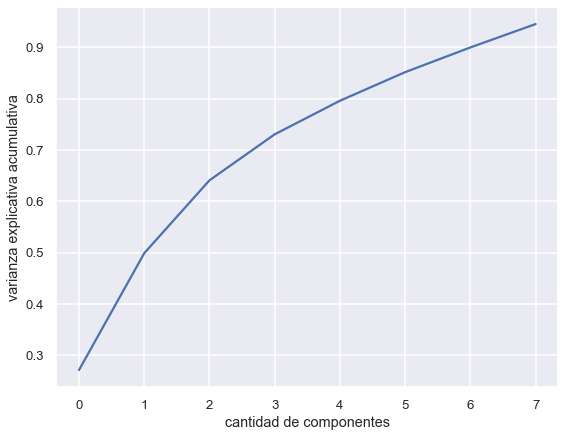

In [268]:
#graficamos el acumulado de varianza explicada en las nuevas dimensiones
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('cantidad de componentes')
plt.ylabel('varianza explicativa acumulativa')
plt.show()

Entrenamiento y predicciones PCA - Random Forest

In [269]:
rfTClassifierPCA = RandomForestClassifier()#inicializacion
rfTClassifierPCA.fit(X_train_pca_t, y_train)#entrenamiento
y_pred_pca_t = rfTClassifierPCA.predict(X_test_pca_t)#prediccion

Evaluación del desempeño modelo PCA - Random Forest

In [270]:
RFTcmPCA = confusion_matrix(y_test, y_pred_pca_t)
print("Modelo Random Forest - PCA")
print(RFTcmPCA)
print('Precisión', accuracy_score(y_test, y_pred_pca_t))

Modelo Random Forest - PCA
[[ 467    7]
 [  10 1466]]
Precisión 0.9912820512820513


Entrenamiento y predicciones PCA - Logistic Regression

In [272]:
lrTClassifierPCA = LogisticRegression(max_iter=100000)#inicializacion
lrTClassifierPCA.fit(X_train_pca_t, y_train)#entrenamiento
y_pred_pca_t = lrTClassifierPCA.predict(X_test_pca_t)#prediccion

Evaluación del desempeño modelo PCA - Logistic Regression

In [273]:
LRTcmPCA = confusion_matrix(y_test, y_pred_pca_t)
print("Modelo Logistic Regression - PCA")
print(LRTcmPCA)
print('Precisión', accuracy_score(y_test, y_pred_pca_t))

Modelo Logistic Regression - PCA
[[ 464   10]
 [   8 1468]]
Precisión 0.9907692307692307


Entrenamiento y predicciones PCA - Gaussian Naive Vayes

In [275]:
gnbTClassifierPCA = GaussianNB()#inicializacion
gnbTClassifierPCA.fit(X_train_pca_t, y_train)#entrenamiento
y_pred_pca_t = gnbTClassifierPCA.predict(X_test_pca_t)#prediccion

Evaluación del desempeño modelo PCA - Gaussian Naive Bayes

In [276]:
GNVTcmPCA = confusion_matrix(y_test, y_pred_pca_t)
print("Modelo Gaussian Naive Bayes - PCA")
print(GNVTcmPCA)
print('Precisión', accuracy_score(y_test, y_pred_pca_t))

Modelo Gaussian Naive Bayes - PCA
[[ 451   23]
 [  20 1456]]
Precisión 0.977948717948718


Como se habia mencionado anteriormente, difícilmente PCA podía mejorar la precisión. Pero si es importante notar como tampoco disminuyó la precisión utilizando menos atributos. Por último, en este caso el rendimiento no se ve tan mejorado considerando que son muy pocos los atributos.

Al tener tan buenos resultados tanto con el conjunto de datos originales como con PCA es innecesario aplicar RFE. Si vamos a aplicar AutoML para ver si existen mejores algoritmos a utiliziar que los utilizados manualmente.

#### AutoML en predicción del tipo de vino

Para este caso, volveremos a utilizar AutoML para desarrollar un modelo óptimo para predecir el tipo de vino en base a sus características fisicoquímicas. Vamos a reutilizar el conjunto de datos cargado anteriormente y solo vamos a cambiar la variable a predecir. Es imporatante recalcar que este ejercicio en términos de AutoML es diferente al anterior, cuando intentamos predecir la calidad del vino hicimos una clasificación múltiple (diferentes calidades de vino), mientras en este caso vamos a hacer una clasificación binaria (solo tinto o blanco). Esto lo veremos reflejado en las estadísticas que AutoML presenta en el ranking de modelos.

Establecemos nuevamente las variables predictoras (X) y la variable dependiente o a predecir (Y)

In [277]:
y = "type"
x = ['fixed_acidity','volatile_acidity','citric_acid','residual_sugar',
    'chlorides','free_sulfur_dioxide','total_sulfur_dioxide',
    'density','pH','sulphates','alcohol']

Estamos listos para utilizar el AutoML, se hará de la misma forma que se hizo anteriormente

In [278]:
aml_type = H2OAutoML(max_runtime_secs=120, seed = 1)
aml_type.train(x = x, y = y, training_frame = train)

AutoML progress: |█
19:09:41.922: AutoML: XGBoost is not available; skipping it.

█████████████████Failed polling AutoML progress log: [WinError 32] El proceso no tiene acceso al archivo porque está siendo utilizado por otro proceso: 'C:\\Users\\Marco\\AppData\\Local\\Temp\\tmpmkrx0mnm.csv'
██████████████████████████████████████| 100%


Una vez que el modelo está entrenado, puede acceder al ranking de modelos generados (leaderboard).

In [279]:
lbT = aml_type.leaderboard
lbT.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_4_AutoML_20200331_190941,0.998982,0.0224611,0.891345,0.00780088,0.0668684,0.00447139
GBM_2_AutoML_20200331_190941,0.998928,0.0224968,0.850599,0.00766467,0.0668284,0.00446603
GBM_1_AutoML_20200331_190941,0.998889,0.02464,0.986052,0.00936461,0.0708422,0.00501862
GBM_3_AutoML_20200331_190941,0.998878,0.0238277,0.934883,0.00831031,0.0702081,0.00492918
GBM_grid__1_AutoML_20200331_190941_model_1,0.998552,0.023686,0.986671,0.00831917,0.0678611,0.00460513
GBM_5_AutoML_20200331_190941,0.99851,0.021844,0.823327,0.0097644,0.0678272,0.00460053
XRT_1_AutoML_20200331_190941,0.9977,0.0544641,0.20136,0.00895595,0.0805789,0.00649296
StackedEnsemble_BestOfFamily_AutoML_20200331_190941,0.997462,0.0208785,0.916943,0.00740995,0.0632818,0.00400458
StackedEnsemble_AllModels_AutoML_20200331_190941,0.997459,0.0212116,0.985785,0.0079371,0.0631953,0.00399365
DRF_1_AutoML_20200331_190941,0.997197,0.0607972,0.264908,0.0102738,0.0820769,0.00673662


Como se puede observar y se mencionó anteriormente, al ser una clasificación binaria la métrica utilizada por AutoML para puntuar los modelos es el AUC.

Para entender que es el AUC, primero hay que entender la curva ROC (curva de característica operativa del recepto). Sin entrar en mucho detalle, la curva ROC es un gráfico que muestra el rendimiento de un modelo de clasificación en todos los umbrales de clasificación. Esta curva representa dos parámetros:<br>
1. Tasa de verdaderos positivos
2. Tasa de falsos positivos
<br>
<br>
Ahora, volviendo a la métrica utilizada por AutoML, AUC significa "área bajo la curva ROC". Esto significa que el AUC mide toda el área bidimensional por debajo de la curva ROC completa.<br>
Una forma de interpretar el AUC es como la probabilidad de que el modelo clasifique un ejemplo positivo aleatorio más alto que un ejemplo negativo aleatorio.<br>
El AUC oscila en valor del 0 al 1. Un modelo cuyas predicciones son un 100% incorrectas tiene un AUC de 0; otro cuyas predicciones son un 100% correctas tiene un AUC de 1. De esta forma podemos decir que entre mayor sea el AUC menos probabilidad de "equivocarse" tendrá el modelo.

Vamos a ver los detalles del mejor algoritmo seleccionado por AutoML, está almacenado el dato leader del AutoML

In [280]:
aml_type.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_4_AutoML_20200331_190941


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,93.0,93.0,93672.0,10.0,10.0,10.0,54.0,112.0,75.39785




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0001982470577098202
RMSE: 0.01408002335615322
LogLoss: 0.0009180416202988866
Mean Per-Class Error: 0.00025471217524197787
AUC: 0.9999996017010552
AUCPR: 0.9880283980400764
Gini: 0.9999992034021103

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5426980002397999: 


,,Red,White,Error,Rate
0,Red,1277.0,2.0,0.0016,(2.0/1279.0)
1,White,0.0,3926.0,0.0,(0.0/3926.0)
2,Total,1277.0,3928.0,0.0004,(2.0/5205.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.542698,0.999745,225.0
1,max f2,0.542698,0.999898,225.0
2,max f0point5,0.964193,0.999898,223.0
3,max accuracy,0.964193,0.999616,223.0
4,max precision,0.999959,1.000000,0.0
5,max recall,0.542698,1.000000,225.0
6,max specificity,0.999959,1.000000,0.0
7,max absolute_mcc,0.964193,0.998965,223.0
8,max min_per_class_accuracy,0.964193,0.999491,223.0
9,max mean_per_class_accuracy,0.964193,0.999745,223.0



Gains/Lift Table: Avg response rate: 75.43 %, avg score: 75.43 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010375,0.999957,1.325777,1.325777,1.000000,0.999959,1.000000,0.999959,0.013754,0.013754,32.577687,32.577687
1,,2,0.020173,0.999955,1.325777,1.325777,1.000000,0.999956,1.000000,0.999957,0.012990,0.026745,32.577687,32.577687
2,,3,0.030163,0.999954,1.325777,1.325777,1.000000,0.999954,1.000000,0.999956,0.013245,0.039990,32.577687,32.577687
3,,4,0.040154,0.999952,1.325777,1.325777,1.000000,0.999953,1.000000,0.999956,0.013245,0.053235,32.577687,32.577687
4,,5,0.050144,0.999951,1.325777,1.325777,1.000000,0.999952,1.000000,0.999955,0.013245,0.066480,32.577687,32.577687
5,,6,0.100096,0.999947,1.325777,1.325777,1.000000,0.999949,1.000000,0.999952,0.066225,0.132705,32.577687,32.577687
6,,7,0.150048,0.999944,1.325777,1.325777,1.000000,0.999946,1.000000,0.999950,0.066225,0.198930,32.577687,32.577687
7,,8,0.200192,0.999941,1.325777,1.325777,1.000000,0.999942,1.000000,0.999948,0.066480,0.265410,32.577687,32.577687
8,,9,0.300096,0.999932,1.325777,1.325777,1.000000,0.999937,1.000000,0.999944,0.132450,0.397860,32.577687,32.577687
9,,10,0.400000,0.999920,1.325777,1.325777,1.000000,0.999927,1.000000,0.999940,0.132450,0.530311,32.577687,32.577687




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.004471386087353537
RMSE: 0.06686842369424852
LogLoss: 0.022461062074659203
Mean Per-Class Error: 0.007774297530108498
AUC: 0.9989820474716581
AUCPR: 0.891344561471526
Gini: 0.9979640949433162

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5452251989451493: 


,,Red,White,Error,Rate
0,Red,1261.0,18.0,0.0141,(18.0/1279.0)
1,White,6.0,3920.0,0.0015,(6.0/3926.0)
2,Total,1267.0,3938.0,0.0046,(24.0/5205.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.545225,0.996948,220.0
1,max f2,0.162453,0.998067,236.0
2,max f0point5,0.922309,0.996179,208.0
3,max accuracy,0.545225,0.995389,220.0
4,max precision,0.999992,1.000000,0.0
5,max recall,0.024596,1.000000,262.0
6,max specificity,0.999992,1.000000,0.0
7,max absolute_mcc,0.545225,0.987541,220.0
8,max min_per_class_accuracy,0.974494,0.990321,184.0
9,max mean_per_class_accuracy,0.922309,0.992226,208.0



Gains/Lift Table: Avg response rate: 75.43 %, avg score: 75.67 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010183,0.999994,1.325777,1.325777,1.000000,0.999994,1.000000,0.999994,0.013500,0.013500,32.577687,32.577687
1,,2,0.020173,0.999993,1.325777,1.325777,1.000000,0.999994,1.000000,0.999994,0.013245,0.026745,32.577687,32.577687
2,,3,0.030163,0.999993,1.325777,1.325777,1.000000,0.999993,1.000000,0.999994,0.013245,0.039990,32.577687,32.577687
3,,4,0.040154,0.999992,1.325777,1.325777,1.000000,0.999993,1.000000,0.999993,0.013245,0.053235,32.577687,32.577687
4,,5,0.050336,0.999992,1.325777,1.325777,1.000000,0.999992,1.000000,0.999993,0.013500,0.066735,32.577687,32.577687
5,,6,0.100096,0.999988,1.325777,1.325777,1.000000,0.999990,1.000000,0.999991,0.065970,0.132705,32.577687,32.577687
6,,7,0.150048,0.999984,1.325777,1.325777,1.000000,0.999986,1.000000,0.999990,0.066225,0.198930,32.577687,32.577687
7,,8,0.200000,0.999977,1.325777,1.325777,1.000000,0.999981,1.000000,0.999987,0.066225,0.265155,32.577687,32.577687
8,,9,0.300096,0.999935,1.325777,1.325777,1.000000,0.999954,1.000000,0.999976,0.132705,0.397860,32.577687,32.577687
9,,10,0.400000,0.999909,1.323227,1.325140,0.998077,0.999922,0.999520,0.999963,0.132196,0.530056,32.322730,32.514009




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.99558115,0.0021046016,0.99231505,0.9961575,0.99807876,0.99519694,0.9961575
1,auc,0.9982977,0.0020563933,0.99579036,0.99988914,0.9963251,0.9996139,0.99986994
2,aucpr,0.9948259,0.0026402764,0.99667484,0.9925235,0.9915024,0.99601203,0.9974167
3,err,0.004418828,0.0021046016,0.007684918,0.003842459,0.0019212295,0.004803074,0.003842459
4,err_count,4.6,2.1908903,8.0,4.0,2.0,5.0,4.0
5,f0point5,0.9960894,0.0018943127,0.9934194,0.9975186,0.997921,0.9948849,0.996703
6,f1,0.99708146,0.0013840839,0.99493027,0.9975186,0.9986996,0.9967969,0.9974619
7,f2,0.99807644,0.0011585746,0.9964458,0.9975186,0.9994794,0.9987163,0.998222
8,lift_top_group,1.3261135,0.023561297,1.3227446,1.2915633,1.3554688,1.3380463,1.3227446
9,logloss,0.022461062,0.011536177,0.041473262,0.01378806,0.018601716,0.024687394,0.013754876



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-03-31 19:10:25,8.366 sec,0.0,0.430516,0.557590,0.500000,0.000000,1.000000,0.245725
1,,2020-03-31 19:10:25,8.427 sec,5.0,0.265335,0.278652,0.999567,0.999598,1.325777,0.004803
2,,2020-03-31 19:10:25,8.513 sec,10.0,0.170924,0.163128,0.999665,0.998864,1.325777,0.003842
3,,2020-03-31 19:10:25,8.598 sec,15.0,0.115947,0.101713,0.999648,0.998596,1.325777,0.002690
4,,2020-03-31 19:10:25,8.664 sec,20.0,0.082646,0.065087,0.999702,0.999633,1.325777,0.002690
5,,2020-03-31 19:10:25,8.739 sec,25.0,0.061964,0.042638,0.999917,0.999717,1.325777,0.001537
6,,2020-03-31 19:10:25,8.813 sec,30.0,0.047782,0.028236,0.999964,0.999479,1.325777,0.000961
7,,2020-03-31 19:10:25,8.877 sec,35.0,0.039313,0.019193,0.999990,0.998723,1.325777,0.000576
8,,2020-03-31 19:10:25,8.954 sec,40.0,0.031968,0.013133,0.999997,0.998471,1.325777,0.000576
9,,2020-03-31 19:10:25,9.016 sec,45.0,0.027095,0.009151,0.999999,0.997453,1.325777,0.000384



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,chlorides,1886.477417,1.000000,0.407254
1,total_sulfur_dioxide,1238.903198,0.656728,0.267455
2,volatile_acidity,578.601440,0.306710,0.124909
3,density,278.295044,0.147521,0.060078
4,residual_sugar,197.502930,0.104694,0.042637
5,sulphates,129.286606,0.068533,0.027910
6,fixed_acidity,81.658905,0.043286,0.017629
7,free_sulfur_dioxide,77.222618,0.040935,0.016671
8,pH,72.484039,0.038423,0.015648
9,alcohol,56.326656,0.029858,0.012160


Como se puede observar los detalles que ofrece AutoML en una clasificación binaria es mucho mayor a la clasificación múltiple, lo cual nos hace pensar en que si aplicamos simple ingenieria de datos a la clasificación de calidad podemos obtener resultados distintos, por ejemplo, podemos clasificar los vinos en 3 categorias: malos, regulares y buenos y con esto podemos facilitar el trabajo del modelo.

Ahora, vamos a llevar a cabo la predicción utilizando el modelo elegido por AutoML

In [281]:
pred = aml_type.predict(test)
pred.head()

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,Red,White
White,6.72078e-05,0.999933
White,6.59336e-05,0.999934
Red,0.999904,9.62582e-05
White,7.14181e-05,0.999929
Red,0.999589,0.000411167
Red,0.999884,0.000115987
White,0.00515224,0.994848
Red,0.999914,8.60946e-05
Red,0.999836,0.000163644
White,5.62814e-05,0.999944


Igual que el modelo anterior podemos evaluar la precisión de la predicción contra el conjunto de pruebas

In [282]:
(pred["predict"] == test["type"]).mean()

[0.9976780185758514]

Dados los resultados presentados, tanto los modelos manuales como los modelos generados por AutoML son altamente precisos, por tanto se consideran como válidos.

#### Optimización de modelo de predicción de calidad de vino

Considerando que el modelo podría llegar a predecir 11 calificaciones distintas (0 a 10) esto dificulta que el modelo pueda tener una precisión alta. Por tanto, se considera reducir las calificaciones a malo (calificación 0 a 3), regular (calificación 4 a 7) y bueno (calificación 8 a 10).

Primero hay que modificar el conjunto de datos para cambiar de 11 calificaciones a 3

In [338]:
datos_originales = pd.read_csv('winequality-final.csv', header=0)

In [345]:
df2 = datos_originales.copy()

In [346]:
df2["quality"].replace({0:"Malo",1:"Malo",2:"Malo",3:"Malo",
                       4:"Regular",5:"Regular",6:"Regular",7:"Regular",
                       8:"Bueno",9:"Bueno",10:"Bueno"}, inplace=True)

In [354]:
df2['quality'] = df2['quality'].astype('category')
df2['type'] = df2['type'].astype('category')

Vamos a generar nuevamente un modelo con el conjunto de datos nuevo

In [356]:
caracteristicasFinal = df2.iloc[:,0:11]
depVarCalidadFinal = df2['quality']

In [357]:
x_train, x_test, y_train, y_test = train_test_split(caracteristicasFinal, 
                                                    depVarCalidadFinal, test_size=0.3, random_state=101)

In [365]:
quality_modelRF_Final = RandomForestClassifier(n_estimators=1000) #random forest
quality_modelLR_Final = LogisticRegression(max_iter=100000) #regresion logistica
quality_modelGNB_Final = GaussianNB() #Gaussian Naive Bayes

In [366]:
quality_modelRF_Final.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [367]:
quality_modelLR_Final.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [368]:
quality_modelGNB_Final.fit(x_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

Revisamos las calificaciones de los nuevos modelos

In [369]:
quality_modelRF_Final.score(x_train,y_train)

1.0

In [370]:
quality_modelLR_Final.score(x_train,y_train)

0.9645920387068396

In [371]:
quality_modelGNB_Final.score(x_train,y_train)

0.8792610512425775

Es claramente notorio que hubo una mejoria en las calificaciones del modelo cambiando de 11 calificaciones a 3, ahora se haran las predicciones con los datos de pruebas

In [375]:
predRFOrigFinal = quality_modelRF_Final.predict(x_test)
cmQualityRFFinal = confusion_matrix(y_test, predRFOrigFinal)
print("Modelo Final Random Forest - Datos Originales - 3 Calificaciones")
print(cmQualityRFFinal)
print('Precisión', accuracy_score(y_test, predRFOrigFinal))

Modelo Final Random Forest - Datos Originales - 3 Calificaciones
[[  26    0   29]
 [   0    0   11]
 [   0    0 1884]]
Precisión 0.9794871794871794


In [376]:
predLROrigFinal = quality_modelLR_Final.predict(x_test)
cmQualityLRFinal = confusion_matrix(y_test, predLROrigFinal)
print("Modelo Final Logistic Regression - Datos Originales - 3 Calificaciones")
print(cmQualityLRFinal)
print('Precisión', accuracy_score(y_test, predLROrigFinal))

Modelo Final Logistic Regression - Datos Originales - 3 Calificaciones
[[   0    0   55]
 [   0    0   11]
 [   0    0 1884]]
Precisión 0.9661538461538461


In [377]:
predGNBOrigFinal = quality_modelGNB_Final.predict(x_test)
cmQualityGNBFinal = confusion_matrix(y_test, predGNBOrigFinal)
print("Modelo Final Gaussian Naive Bayes - Datos Originales - 3 Calificaciones")
print(cmQualityGNBFinal)
print('Precisión', accuracy_score(y_test, predGNBOrigFinal))

Modelo Final Gaussian Naive Bayes - Datos Originales - 3 Calificaciones
[[  16    0   39]
 [   0    3    8]
 [ 156   24 1704]]
Precisión 0.8835897435897436


Si se realizan las matrices de confusión de los modelos generados con los datos que contienen únicamente 3 calificaciones posibles para los vinos(malo, regular y bueno), se observa una excelente mejoría en la precisión de los modelos. Lo que se realizó fue una ingeniería de la variable dependiente, de esta forma "ayudamos" al modelo a procesar los datos de una forma más simple y por ende esto se ve reflejado en la precisión de las predicciones.

### Conclusiones:

Como conclusiones del presente proyecto se puede mencionar:<br>
1. Desde el punto de vista de análisis inicial, se encontró una relación no tan marcada entre la calidad del vino y sus grados de alcohol, pero si fue importante observar que la mayor concentracion de vinos de calidad 5 o superior se encuentran entre los 10 y los 14 grados de alcohol. Un productor de vino podría considerar en aumentar su rentabilidad concentrandose en estos rangos de grados de alcohol considerando que un vino de mayor calidad se puede vender a un precio superior.
2. Fue muy complicado encontrar un algoritmo capaz de clasificar con alta precisión la calidad de los vinos utilizando la escala de 0 a 10. Para solventar esta problemática se aplicó algo de ingeniería sobre la variable dependiente (a predecir) disminuyendo la cantidad de posibles calificaciones de 11 a 3 (malo, regular y bueno). De esta forma se logró un aumento del un 68% de precisión a un 98%.
3. Predecir de que tipo es un vino (tinto o blanco) basado en sus características fue muy simple con todos los modelos desarrollados con una precisión bastante alta (entre 88% hasta 97% según el modelo).
4. Desde el punto de vista técnico la utilización de AutoML es una gran ayuda en el análisis de datos, ya que permite obtener resultados de una forma muy simple, sin tener que pensar en el preprocesamiento de los datos ni la construcción y optimización de varios modelos, simplemente permite enfocarse en cuales son las variables predictoras, y cual es la variable a predecir, y con esto AutoML se encarga de generar diferentes modelos y escoger el mejor. Personalmente considero que es una herramienta muy útil en generación de modelos iniciales, los cuales posteriormente pueden ser mejorados, ahorrando mucho tiempo en fases iniciales.